In [1]:
from matplotlib import pyplot as plt ; from matplotlib import colors
%matplotlib inline
import numpy as np; import numpy.ma as ma; from matplotlib.patches import Path, PathPatch
import pandas as pd; from shapely.geometry import Point, shape, Polygon;import fiona
from shapely.ops import unary_union, cascaded_union; from geopandas.tools import sjoin
import geopandas as gpd; import glob; import os; from datetime import timedelta, date;
from netCDF4 import Dataset
import scipy.ndimage; from cartopy import crs as ccrs; from cartopy.io.shapereader import Reader
import matplotlib.path as mpath; import seaborn as sns
import xarray as xr
import datetime as dt
import matplotlib
import mne
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz.utils import center_cmap
from matplotlib.colors import Normalize

In [2]:
# Find index of points on a gridded array
# stn_lon,stn_lat = list of lat lon points --> lat_list, lon_list = [x1,x2][y1,y2]
# wrf_lon, wrf_lat = np.array of gridded lat lon --> grid_x= np.array([x1,x2,x3],[x4,x5,x6])
def find_index(stn_lon, stn_lat, wrf_lon, wrf_lat):
 # stn -- points in a list (list, can be a list of just 1) 
 # wrf -- gridded wrf lat/lon (np.array)
 #for iz in range(1):
    xx=[];yy=[]
    for i in range(len(stn_lat)):
       abslat = np.abs(wrf_lat-stn_lat[i])
       abslon= np.abs(wrf_lon-stn_lon[i])
       c = np.maximum(abslon,abslat)
       latlon_idx = np.argmin(c)
       x, y = np.where(c == np.min(c))
       #add indices of nearest wrf point station
       xx.append(x)
       yy.append(y)
    #
    xx=[xx[i][0] for i in range(len(xx))];yy=[yy[i][0] for i in range(len(yy))]
    #return indices list
    return xx, yy

In [3]:
def crop_array(x1,y1,x2,y2,x3,y3,x4,y4,lon,lat,gridded_var):
#''''''''''''''''''''''
# x1,y1,x2,y2,x3,y3,x4,y4 = indices of corners of cropping function
# lon,lat,gridded_var = grid of lons, lats, and variable
#''''''''''''''''''''''
#for i in range(1):
    # Make box around chicago to cut data -- specific for satellite, check to make sure the arrays are increasing in size
    # converting lat lon corners to index corners
    #set up zeros array given the bounds
    diffy =max(y1i,y2i,y3i,y4i)[0]-min(y1i,y2i,y3i,y4i)[0]
    diffx=max(x1i,x2i,x3i,x4i)[0]-min(x1i,x2i,x3i,x4i)[0]
    zlon,zlat,z=np.zeros([diffx, diffy]), np.zeros([diffx, diffy]), np.zeros([diffx, diffy])
    # fill out zeros array from the gridded data
    for i in range(diffx):
       for j in range(diffy):
          z[i][j]= gridded_var[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
          zlat[i][j]= lat[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
          zlon[i][j]= lon[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
    #return values
    return zlon,zlat,z

In [4]:
# Lat and lon for smoke files
lat_lon = '/projects/b1045/jschnell/ForAmy/latlon_ChicagoLADCO_d03.nc'
ll=Dataset(lat_lon)
lat,lon=ll['lat'][:],ll['lon'][:]

In [5]:
# define statics
path = '/home/alr4786/geo_export_2f188c58-0852-485a-8c23-29a5272d17d1.shp'
chi  = gpd.GeoDataFrame.from_file(path)
var=['PEC','VOC_INV', 'NO','NO2']
buffer = 0.1

In [6]:
# Read in smoke files and unzip for base case
smoke_files=[]
for file in glob.glob("/projects/b1045/jschnell/ForAmy/smoke_out/base/emis_mole_onroad*.ncf"):
    smoke_files.append(file)

smoke_files.sort();
smoke=[Dataset(smoke_files[i]) for i in range(len(smoke_files))]

# Read in smoke files and unzip for no municipal case
smoke_files_nm=[]
for file in glob.glob("/projects/b1045/jschnell/ForAmy/smoke_out/emissions__no_municipal_vehicles/emis_mole_onroad*.ncf"):
    smoke_files_nm.append(file)

smoke_files_nm.sort();
smoke_nm=[Dataset(smoke_files_nm[i]) for i in range(len(smoke_files_nm))]


# Read in files with no bus vehicle emissions 
smoke_bus_files=[]
for file in glob.glob("/projects/b1045/jschnell/ForAmy/smoke_out/emissions_no_bus/emis_mole*.ncf"):
    smoke_bus_files.append(file)
    
smoke_bus_files.sort();
smoke_nb=[Dataset(smoke_bus_files[i]) for i in range(len(smoke_bus_files))]

# Read in files with no school vehicle emissions 
smoke_school_files=[]
for file in glob.glob("/projects/b1045/jschnell/ForAmy/smoke_out/emissions_no_school/emis_mole*.ncf"):
    smoke_school_files.append(file)

smoke_school_files.sort();
smoke_ns=[Dataset(smoke_school_files[i]) for i in range(len(smoke_school_files))]

In [32]:
# Select the files from the month of August
smoke_nb = smoke_nb[32:64]
smoke_ns = smoke_ns[32:64]
smoke_nm = smoke_nm[31:62]
smoke = smoke[32:64]

In [31]:
### CROP THE FILE TO BE THE SIZE OF CHICAGO. THE WHOLE DOMAIN IS OF THE GREAT LAKES REGION
# start cropping
smoke_crop = [[] for i in range(len(var))]
# s.t. --> no_crop,pec_crop,so2_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop SMOKE variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(smoke)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(smoke[j][var[i]][h][0])
            slon,slat,s = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            smoke_crop[i].append(s)

In [32]:
# SAVE CROPED ARRAY BECAUSE IT TAKE A LONG TIME TO CROP EVERY TIME
%store smoke_crop

Stored 'smoke_crop' (list)


In [34]:
# start cropping
smoke_crop_nm = [[] for i in range(len(var))]
# s.t. --> no_crop,pec_crop,so2_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop SMOKE variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(smoke_nm)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(smoke_nm[j][var[i]][h][0])
            slon,slat,s = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            smoke_crop_nm[i].append(s)

In [35]:
%store smoke_crop_nm

Stored 'smoke_crop_nm' (list)


In [33]:
# start cropping
smoke_crop_nb = [[] for i in range(len(var))]
# s.t. --> no_crop,pec_crop,so2_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop SMOKE variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(smoke_nb)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(smoke_nb[j][var[i]][h][0])
            slon,slat,s = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            smoke_crop_nb[i].append(s)

In [34]:
%store smoke_crop_nb

Stored 'smoke_crop_nb' (list)


In [35]:
# start cropping
smoke_crop_ns = [[] for i in range(len(var))]
# s.t. --> no_crop,pec_crop,so2_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop SMOKE variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(smoke_ns)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(smoke_ns[j][var[i]][h][0])
            slon,slat,s = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            smoke_crop_ns[i].append(s)

In [36]:
%store smoke_crop_ns

Stored 'smoke_crop_ns' (list)


In [6]:
%store -r smoke_crop
%store -r smoke_crop_nb
%store -r smoke_crop_ns
%store -r zlon
%store -r zlat
%store -r smoke_crop_no_mun

In [7]:
def nox_calc(crop_array): 
    for i in range(len(crop_array[0])): 
        crop_array[2][i] = crop_array[2][i] + crop_array[3][i]
    return crop_array

In [9]:
len(smoke_crop_nb[0])

744

In [10]:
smoke_final = nox_calc(smoke_crop)
smoke_final_nb = nox_calc(smoke_crop_nb)
smoke_final_ns = nox_calc(smoke_crop_ns) 
#smoke_final_nm = nox_calc(smoke_crop_no_mun)

In [12]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
tmp_nox = []
tmp_pec = []
tmp_voc = []

for day in days:
    for hr in hours:
        tmp_nox.append([smoke_final[2][day+hours[hr]]*259])

monthly_av_nox=np.average(tmp_nox,axis=0)

for day in days:
    for hr in hours:
        tmp_voc.append([smoke_final[1][day+hours[hr]]*2.89688])

monthly_av_voc=np.average(tmp_voc,axis=0)
    
    
for day in days:
    for hr in hours:
        tmp_pec.append([smoke_final[0][day+hours[hr]]*2.89688])
        
monthly_av_pec=np.average(tmp_pec,axis=0)

In [13]:
monthly_av_nox = pd.DataFrame(monthly_av_nox[0])
monthly_av_pec = pd.DataFrame(monthly_av_pec[0])
monthly_av_voc = pd.DataFrame(monthly_av_voc[0])

In [14]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
tmp_nox_nm = []
tmp_pec_nm = []
tmp_voc_nm = []
for day in days:
    for hr in hours:
        tmp_nox_nm.append([smoke_final_nm[2][day+hours[hr]]*259])

monthly_av_nox_nm=np.average(tmp_nox_nm,axis=0)

for day in days:
    for hr in hours:
        tmp_voc_nm.append([smoke_final_nm[1][day+hours[hr]]*2.89688])
    
monthly_av_voc_nm=np.average(tmp_voc_nm,axis=0)
    
for day in days:
    for hr in hours:
        tmp_pec_nm.append([smoke_final_nm[0][day+hours[hr]]*2.89688])
        
monthly_av_pec_nm=np.average(tmp_pec_nm,axis=0)

NameError: name 'smoke_final_nm' is not defined

In [43]:
monthly_av_nox_nm = pd.DataFrame(monthly_av_nox_nm[0])
monthly_av_pec_nm = pd.DataFrame(monthly_av_pec_nm[0])
monthly_av_voc_nm = pd.DataFrame(monthly_av_voc_nm[0])

In [44]:
monthly_dif_nox = monthly_av_nox_nm - monthly_av_nox
monthly_dif_pec = monthly_av_pec_nm - monthly_av_pec
monthly_dif_voc = monthly_av_voc_nm - monthly_av_voc

In [15]:
# FIND THE MONTHLY AVERAGE AND CHANGE TO CORRECT UNITS
av_pec = pd.DataFrame(np.average(smoke_final[0], axis = 0)*2.89688)
av_voc = pd.DataFrame(np.average(smoke_final[1], axis = 0)*2.89688)
av_nox = pd.DataFrame(np.average(smoke_final[2], axis = 0)*259)

av_pec_nb = pd.DataFrame(np.average(smoke_final_nb[0], axis = 0)*2.89688)
av_voc_nb = pd.DataFrame(np.average(smoke_final_nb[1], axis = 0)*2.89688)
av_nox_nb = pd.DataFrame(np.average(smoke_final_nb[2], axis = 0)*259)

av_pec_ns = pd.DataFrame(np.average(smoke_final_ns[0], axis = 0)*2.89688)
av_voc_ns = pd.DataFrame(np.average(smoke_final_ns[1], axis = 0)*2.89688)
av_nox_ns = pd.DataFrame(np.average(smoke_final_ns[2], axis = 0)*259)

In [16]:
pec_nb_dif = av_pec_nb - av_pec
voc_nb_dif = av_voc_nb - av_voc
nox_nb_dif = av_nox_nb - av_nox

pec_ns_dif = av_pec_ns - av_pec
voc_ns_dif = av_voc_ns - av_voc
nox_ns_dif = av_nox_ns - av_nox

In [72]:
smoke_nb[1]['VOC_INV'][1]

masked_array(
  data=[[[0.01551486, 0.01857669, 0.01723107, ..., 0.04066933,
          0.01603433, 0.02585456],
         [0.01253484, 0.01327376, 0.01290515, ..., 0.03264973,
          0.02411161, 0.03522364],
         [0.01370296, 0.0169018 , 0.03679825, ..., 0.01075906,
          0.01812373, 0.00717086],
         ...,
         [0.04773074, 0.03366376, 0.0420073 , ..., 0.4129834 ,
          0.49917695, 0.3852206 ],
         [0.00350478, 0.00289836, 0.00819789, ..., 0.20550519,
          0.29384908, 0.18968073],
         [0.00398101, 0.00159182, 0.00150221, ..., 0.00429877,
          0.00496706, 0.00484445]]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

## PLOTTING (nox, pec, voc)

In [45]:
# Plot projection
crs_new = ccrs. AlbersEqualArea(central_longitude=(chi.bounds.mean().minx+chi.bounds.mean().maxx)/2)
# get shape outside
union=gpd.GeoSeries(unary_union(chi.geometry))
outsideofunion=pd.DataFrame([list(union[0][2].exterior.xy)[0], list(union[0][2].exterior.xy)[1]])

In [46]:
# Calculate levels for plotting 
monthly_avs = [monthly_dif_nox, monthly_dif_pec, monthly_dif_voc]
maxs = []
mins = []
for i in range(len(monthly_avs)):
    maxs.append(monthly_avs[i].max().max())
    mins.append(monthly_avs[i].min().min())

no_level = np.arange(0, 53.5, 2.5)
pec_level = np.arange(0, .165, 0.005)

Text(0, 0.5, 'ton/month')

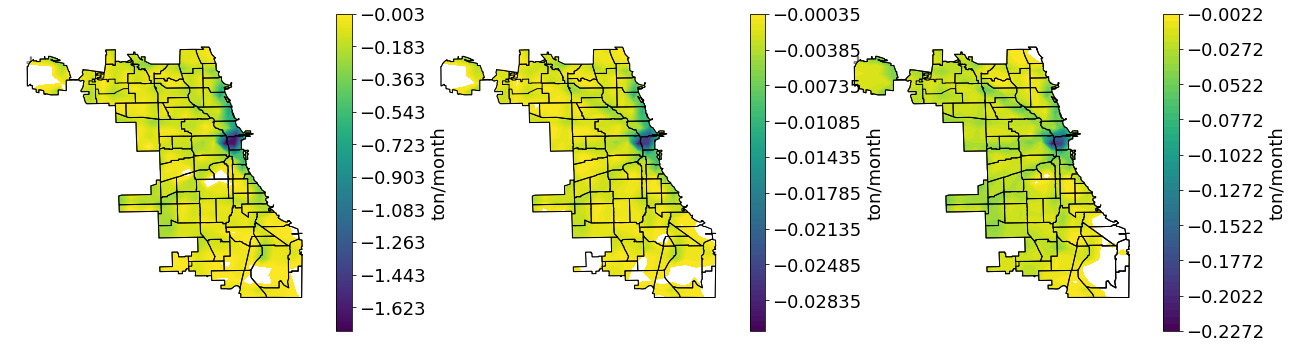

In [49]:
%matplotlib inline
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

fig, (axs1, axs2, axs3) = plt.subplots(1,3,subplot_kw={'projection': crs_new},figsize=(21, 12))

# NO Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,monthly_dif_nox, transform=crs_new, levels=np.arange(mins[0], 0, 0.005), cmap = "viridis")
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)

# pec Plot
chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,monthly_dif_pec, transform=crs_new, levels=np.arange(mins[1], 0, 0.0005), cmap = "viridis")
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


#voc Plot
chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon,zlat,monthly_dif_voc, transform=crs_new, levels=np.arange(mins[2], 0, 0.005), cmap = "viridis")
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)



#add colorbar and label
cbar1 = plt.colorbar(cs1, ax = axs1,fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 
cbar2 = plt.colorbar(cs2, ax = axs2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 
cbar3 = plt.colorbar(cs3, ax = axs3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 

cbar1.ax.set_ylabel('ton/month', size = 18)
cbar2.ax.set_ylabel('ton/month', size = 18)
cbar3.ax.set_ylabel('ton/month', size = 18)

#fig.savefig("/home/alr4786/base_minus_EV_monthly_av.pdf")